## Домашнее задание 1. Обучение LeNet

На прошлой лабораторной мы рассмотрели пример обучения небольшой нейронной сети для классификации датасета CIFAR-10. В качестве домашнего задания вам предлагается классификация предметов одежды из датасета [**Fashion MNIST**](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST). Вы можете начать с имплементации классической сверточной сети [LeNet](https://en.wikipedia.org/wiki/LeNet) и улучшить ее методами, которые мы обсудили на лекции (dropout, batchnorm, etc).

In [1]:
import torchvision
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from copy import deepcopy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Загрузка датасета
fashion_mnist_dataset = torchvision.datasets.FashionMNIST(root="fashion", download=True, transform=transforms.ToTensor())
# Содержит 60000 семплов и 10 классов
images = fashion_mnist_dataset.data.view([60000, 1, 28, 28]).float()

labels = deepcopy(fashion_mnist_dataset.targets)
# labels = deepcopy(fashion_mnist_dataset.targets) - 1

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.01)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
batch_size = 128

In [3]:
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_data, batch_size=len(val_data))

## Архитектура LeNet

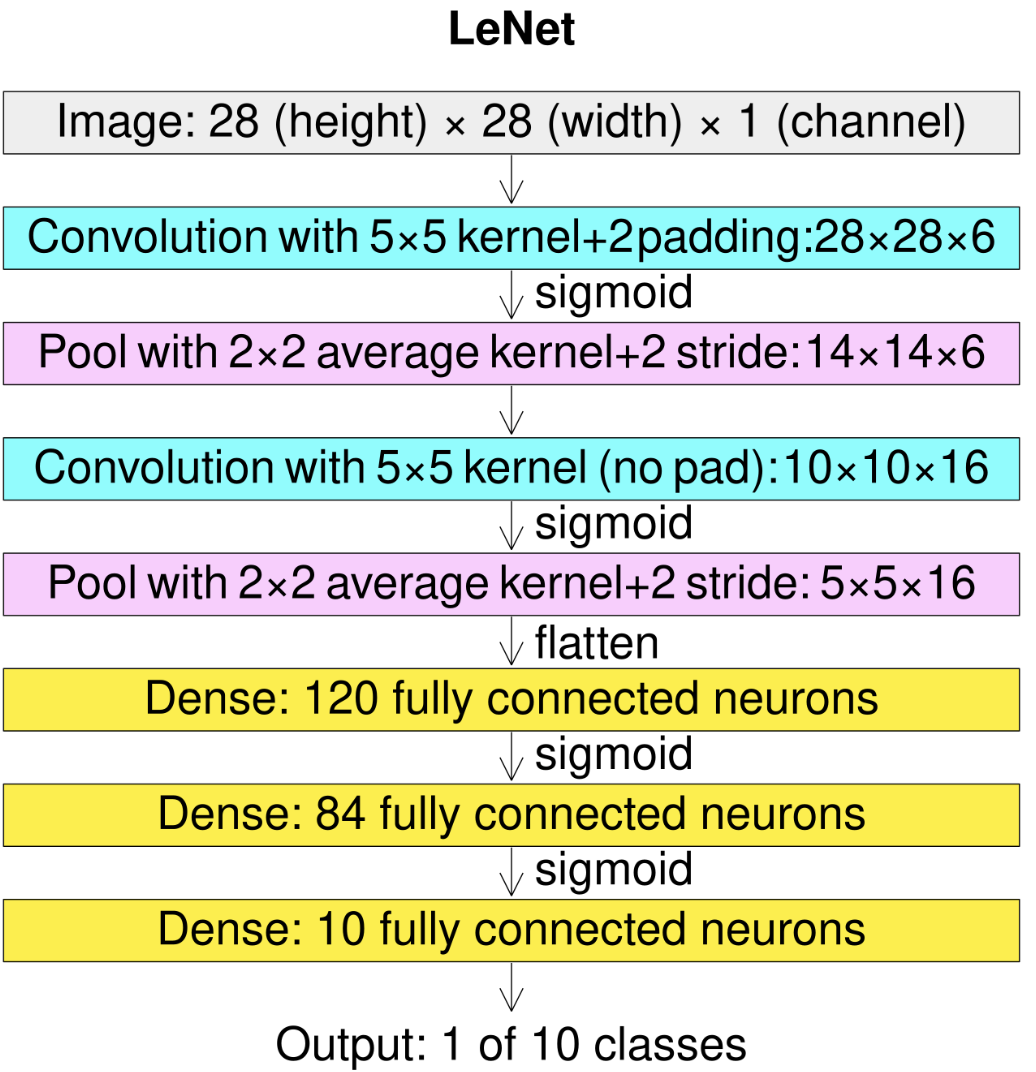



### **Задание 1**: закончите имплементацию LeNet согласно диаграме сверху

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Свертка 1: вход 1 канал, выход 6 каналов, ядро 5x5, паддинг 2
        self.conv_layers = nn.Sequential(
            # Свертка 1: вход 1 канал, выход 6 каналов, ядро 5x5, паддинг 2
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14

            # Свертка 2: вход 6 каналов, выход 16 каналов, ядро 5x5, без паддинга
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),  # 14x14 -> 10x10
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2)  # 10x10 -> 5x5
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=16 * 5 * 5, out_features=120),
            nn.Sigmoid(),
            nn.Linear(in_features=120, out_features=84),
            nn.Sigmoid(),
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return F.log_softmax(x, dim=1)

### **Задание 2**: Напишите функцию обучения

Вы можете воспользоваться кодом из прошлой лабораторной работы

Посчитайте точность на валидационном сете.

In [5]:
def train_one_epoch(model, device, train_loader, criterion, optimizer):
    """
    Обучение модели на одной эпохе.
    """
    model.train()  # Переводим модель в режим обучения
    epoch_loss = 0
    correct = 0
    iteration = 0

    # tqdm показывает прогресс по батчам
    bar = tqdm(train_loader, desc="Training", leave=False)
    for data, target in bar:
        data, target = data.to(device), target.to(device)  # Переносим данные на устройство (GPU/CPU)
        optimizer.zero_grad()  # Обнуляем градиенты

        output = model(data)  # Прямой проход
        loss = criterion(output, target)  # Вычисляем функцию потерь
        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Обновляем веса

        # Предсказания и подсчет количества верных
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        epoch_loss += loss.item()
        iteration += 1

        # Обновляем прогресс-бар
        bar.set_postfix({"Loss": f"{epoch_loss / iteration:.6f}"})

    # Вычисляем среднюю точность за эпоху
    acc = 100. * correct / len(train_loader.dataset)
    return epoch_loss / iteration, acc


def validate(model, device, val_loader, criterion):
    """
    Валидация модели на валидационном датасете.
    """
    model.eval()  # Переводим модель в режим оценки
    val_loss = 0
    correct = 0

    with torch.no_grad():  # Отключаем градиенты (ускоряет и экономит память)
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)  # Прямой проход
            val_loss += criterion(output, target).item()  # Суммируем потери

            # Предсказания и подсчет
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Средняя потеря и точность
    acc = 100. * correct / len(val_loader.dataset)
    avg_loss = val_loss / len(val_loader)
    return avg_loss, acc

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Функция построения графиков
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # График Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # График Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def train_model(model, train_dl, val_dl, epochs=10, learning_rate=0.001, device='cpu'):
    """
    Главная функция обучения модели.
    """
    model.to(device)  # Переносим модель на устройство
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Оптимизатор Adam
    criterion = nn.NLLLoss()  # Функция потерь. Используем NLLLoss вместо CrossEntropyLoss,
                              # так как CrossEntropyLoss = log_softmax + NLLLoss

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = 0.0  # <- хранит лучшую метрику
    best_epoch = 0
    
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")

        # Обучение на одной эпохе
        train_loss, train_acc = train_one_epoch(model, device, train_dl, criterion, optimizer)

        # Валидация на текущей эпохе
        val_loss, val_acc = validate(model, device, val_dl, criterion)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
        
        # Логирование результатов
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")
        
    print(f"\n Best Validation Accuracy: {best_val_acc:.2f}% (epoch {best_epoch})")
        
        # Визуализация после обучения
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = LeNet().to(device)

print(f'Device: {device}')

print(model)

Device: cpu
LeNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)



Epoch 1/10


Train Loss: 1.2257 | Train Acc: 54.48%
Val   Loss: 0.7851 | Val   Acc: 71.00%

Epoch 2/10


Train Loss: 0.6488 | Train Acc: 75.30%
Val   Loss: 0.5987 | Val   Acc: 76.67%

Epoch 3/10


Train Loss: 0.5552 | Train Acc: 78.26%
Val   Loss: 0.5324 | Val   Acc: 80.50%

Epoch 4/10


Train Loss: 0.4961 | Train Acc: 81.26%
Val   Loss: 0.5067 | Val   Acc: 81.17%

Epoch 5/10


Train Loss: 0.4561 | Train Acc: 83.15%
Val   Loss: 0.4763 | Val   Acc: 82.33%

Epoch 6/10


Train Loss: 0.4277 | Train Acc: 84.27%
Val   Loss: 0.4408 | Val   Acc: 82.83%

Epoch 7/10


Train Loss: 0.4024 | Train Acc: 85.14%
Val   Loss: 0.4338 | Val   Acc: 82.33%

Epoch 8/10


Train Loss: 0.3824 | Train Acc: 85.83%
Val   Loss: 0.4280 | Val   Acc: 83.83%

Epoch 9/10


Train Loss: 0.3639 | Train Acc: 86.46%
Val   Loss: 0.4047 | Val   Acc: 83.67%

Epoch 10/10


Train Loss: 0.3515 | Train Acc: 87.07%
Val   Loss: 0.4203 | Val   Acc: 83.83%

 Best Validation Accuracy: 83.83% (epoch 8)


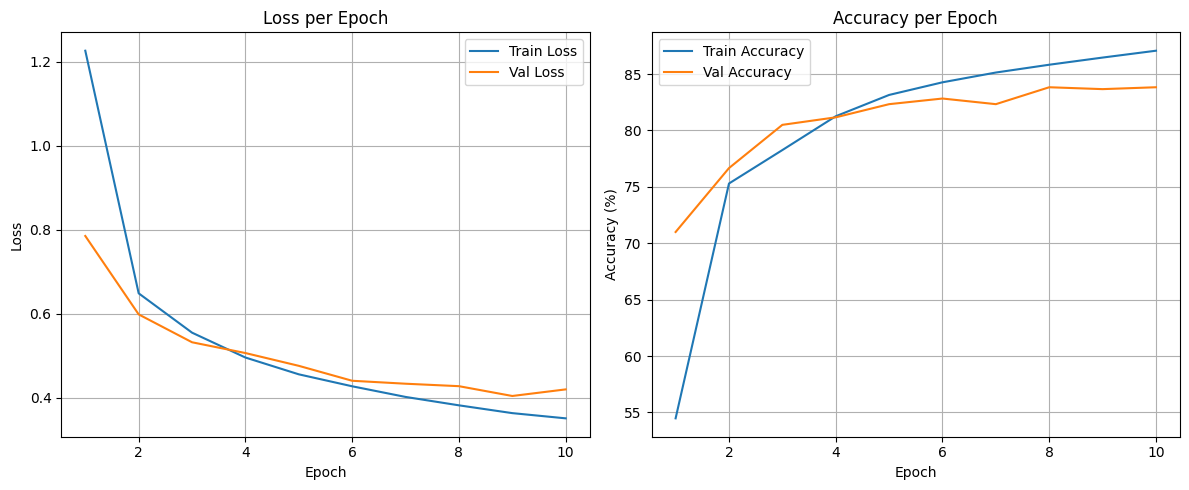

In [7]:
train_model(model, train_dl, val_dl, epochs=10, learning_rate=0.001, device=device)

### **Задание 3**: Улучшите обучение продвинутыми методами

Вы можете добавить
- Dropout;
- BatchNorm;
- Data augmentation;
- Больше сверток к сети;
- Функции активации (ReLU, tahn, etc);
- Adam optimizer вместе с LR scheduler

| **Улучшение** | **Зачем нужно** |
|----------|----------|
| BatchNorm    | Ускоряет и стабилизирует обучение, уменьшает зависимость от начальной инициализации    |
| Dropout    | Помогает бороться с переобучением, случайно "отключая" нейроны   | 
| ReLU    | Быстрая и эффективная активация, помогает избежать затухающего градиента   |
| More Conv    | Больше слоев = возможность выделять более сложные паттерны   |
| Adam + LR Scheduler    |Современная оптимизация + контроль скорости обучения по эпохам    |
| Data Augmentation    | Виртуальное увеличение тренировочного датасета  |


**Аугментацию пока не использовал, остальные способы добавил.**

In [8]:
class FashionLeNet(nn.Module):
    def __init__(self):
        super(FashionLeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # [B, 1, 28, 28] -> [B, 32, 28, 28]
            nn.BatchNorm2d(32), # Стабилизирует обучение, ускоряет сходимость
            nn.ReLU(), # Функция активации

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # [B, 32, 28, 28] -> [B, 64, 28, 28]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # Снижение размерности: [B, 64, 14, 14]
            nn.Dropout(0.25),  # Регуляризация — снижает переобучение

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # [B, 64, 14, 14] -> [B, 128, 14, 14]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), # [B, 128, 7, 7]
            nn.Dropout(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(), # Сглаживание, преобразуем [B, 128, 7, 7] -> [B, 6272]
            nn.Linear(128 * 7 * 7, 256), # Полносвязный слой: сжатие признаков до 256
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x # Без softmax — он включён в CrossEntropyLoss

In [9]:
def train_model_new(model, train_dl, val_dl, epochs=10, learning_rate=0.001, device='cpu'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    best_val_acc = 0.0  # <- хранит лучшую метрику
    best_epoch = 0

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        train_loss, train_acc = train_one_epoch(model, device, train_dl, criterion, optimizer)
        val_loss, val_acc = validate(model, device, val_dl, criterion)
        scheduler.step()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")
    
    print(f"\n Best Validation Accuracy: {best_val_acc:.2f}% (epoch {best_epoch})")

    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_new = FashionLeNet().to(device)

print(f'Device: {device}')

print(model_new)

Device: cpu
FashionLeNet(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): BatchNorm1


Epoch 1/10


Train Loss: 0.3957 | Train Acc: 85.85%
Val   Loss: 0.3224 | Val   Acc: 88.00%

Epoch 2/10


Train Loss: 0.2691 | Train Acc: 90.14%
Val   Loss: 0.2512 | Val   Acc: 90.67%

Epoch 3/10


Train Loss: 0.2346 | Train Acc: 91.43%
Val   Loss: 0.2125 | Val   Acc: 91.67%

Epoch 4/10


Train Loss: 0.2120 | Train Acc: 92.24%
Val   Loss: 0.2113 | Val   Acc: 91.50%

Epoch 5/10


Train Loss: 0.2007 | Train Acc: 92.61%
Val   Loss: 0.2016 | Val   Acc: 93.33%

Epoch 6/10


Train Loss: 0.1659 | Train Acc: 93.93%
Val   Loss: 0.2009 | Val   Acc: 92.17%

Epoch 7/10


Train Loss: 0.1553 | Train Acc: 94.37%
Val   Loss: 0.1947 | Val   Acc: 92.83%

Epoch 8/10


Train Loss: 0.1458 | Train Acc: 94.64%
Val   Loss: 0.1970 | Val   Acc: 93.00%

Epoch 9/10


Train Loss: 0.1388 | Train Acc: 95.02%
Val   Loss: 0.2095 | Val   Acc: 91.67%

Epoch 10/10


Train Loss: 0.1307 | Train Acc: 95.18%
Val   Loss: 0.2151 | Val   Acc: 92.17%

 Best Validation Accuracy: 93.33% (epoch 5)


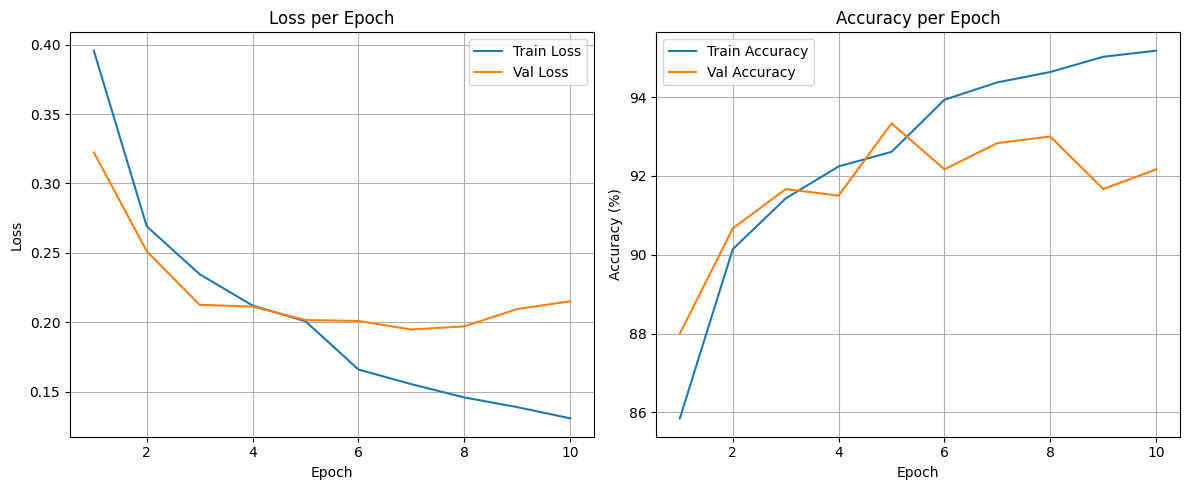

In [11]:
train_model_new(model_new, train_dl, val_dl, epochs=10, learning_rate=0.001, device=device)

**Благодаря улучшению модели смогли повысить accuracy модели до 93.33%!**